In [2]:
import numpy as np
from scipy.interpolate import BSpline
from scipy.linalg import eigh
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:
def knotssq(a, b, N_linear, N_nonuniform, transition, scheme):
    linear_knots = np.linspace(a, transition, N_linear, endpoint=False)
    
    if scheme == 'exponential':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * (np.exp(s) - 1) / (np.e - 1)
    elif scheme == 'quadratic':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * s**2
    
    return np.concatenate((linear_knots, nonuniform_knots))

a, b = 0.0, 10.0
transition = 3.0 
N_linear = 50    
N_nonuniform = 70

#nknots = 5 
#knots = np.linspace(a, b, nknots)
knots = knotssq(a, b, N_linear, N_nonuniform, transition, scheme='exponential')
degree = 3       
augmented_knots = np.concatenate((np.repeat(knots[0], degree), knots, np.repeat(knots[-1], degree)))
n_basis = len(augmented_knots) - degree - 1
collocation_pts = knots  

def B(augmented_knots, degree, n_basis, nquad):
    unique_knots = collocation_pts
    B_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        a_int = unique_knots[i_int]
        b_int = unique_knots[i_int + 1]
        if np.isclose(b_int, a_int):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (b_int - a_int) * x_quad + 0.5 * (b_int + a_int)
        w_mapped = 0.5 * (b_int - a_int) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
    
        for i in range(n_basis):
            for j in range(i, n_basis):
                integrand = B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * integrand)
                B_matrix[i, j] += integral_value
                if i != j:
                    B_matrix[j, i] += integral_value
    
    return B_matrix

B_matrix = B(augmented_knots, degree, n_basis, nquad=5)
B_reduced = B_matrix[1:-1, 1:-1] 

def spherical_potential(r, Z, R0):
    return np.where(r < R0, -Z * ((3.0/(2*R0)) - (r**2)/(2*R0**3)), -Z / r)

def H(augmented_knots, degree, n_basis, nquad, l, Z, R0=None, V_ee_interp=None):
    unique_knots = collocation_pts
    H_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        t_start = unique_knots[i_int]
        t_end = unique_knots[i_int + 1]
        if np.isclose(t_end, t_start):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (t_end - t_start) * x_quad + 0.5 * (t_end + t_start)
        w_mapped = 0.5 * (t_end - t_start) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        B_der_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
            B_der_vals[i, :] = spline.derivative(nu=1)(x_mapped)

        if R0 is not None:
            V_nuclear = spherical_potential(x_mapped, Z, R0)
        else:
            V_nuclear = -Z / x_mapped
        
        V_eff = V_nuclear + (l * (l + 1)) / (2.0 * x_mapped**2)

        if V_ee_interp is not None:
            V_ee_vals = V_ee_interp(x_mapped)
            V_eff += V_ee_vals  

        for i in range(n_basis):
            for j in range(i, n_basis):
                kinetic_integrand = 0.5 * B_der_vals[i, :] * B_der_vals[j, :]
                potential_integrand = V_eff * B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * (kinetic_integrand + potential_integrand))
                H_matrix[i, j] += integral_value
                if i != j:
                    H_matrix[j, i] += integral_value
    return H_matrix

A = np.zeros((len(collocation_pts), n_basis))
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1  
    B_j = BSpline(augmented_knots, coeffs, degree)
    B_j_dd = B_j.derivative(nu=2)
    A[:, j] = B_j_dd(collocation_pts)

new_row = np.zeros(n_basis)
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    new_row[j] = B_j(b)
A_bc = np.vstack([A, new_row])   
A_reduced = A_bc[:, 1:]

def run_scf(Z, occupied_states, r_vals, collocation_pts, augmented_knots, degree, n_basis, B_reduced, A_reduced, max_iter=50, tolerance=1e-6, eta=0.4):
    V_dir_ee_old = np.zeros_like(r_vals)
    E_old_list = None

    for iteration in range(max_iter):
        V_ee_interp = interp1d(r_vals, V_dir_ee_old, kind='cubic', fill_value="extrapolate")
        total_rho_r = np.zeros_like(r_vals)
        orbital_data = []
        eigen_cache = {}

        for state in occupied_states:
            n_index = state["n_index"]
            l = state["l"]
            occ = state["occ"]

            if l not in eigen_cache:
                H_matrix = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=None, V_ee_interp=V_ee_interp)
                H_reduced = H_matrix[1:-1, 1:-1]
                evals, evecs = eigh(H_reduced, B_reduced)
                eigen_cache[l] = (evals, evecs)

            evals, evecs = eigen_cache[l]
            eigval = evals[n_index]
            eigvec = evecs[:, n_index]
            c_full = np.zeros(n_basis)
            c_full[1:-1] = eigvec
            phi_spline = BSpline(augmented_knots, c_full, degree, extrapolate=False)
            P_vals = phi_spline(r_vals)

            total_rho_r += (occ / (4 * np.pi)) * (P_vals / r_vals)**2

            orbital_data.append({
                "n_index": n_index,
                "l": l,
                "occ": occ,
                "eigenvalue": eigval,
                "P_vals": P_vals,
                "phi_spline": phi_spline
            })

        V_exch_ee = -3 * ((3 * total_rho_r) / (8 * np.pi))**(1/3)

        rho_interp = interp1d(r_vals, total_rho_r, kind='cubic', fill_value="extrapolate")
        rho_collocation = rho_interp(collocation_pts)
        rhs = -collocation_pts * 4 * np.pi * rho_collocation
        b_bc = np.append(rhs, Z)
        c_reduced = np.linalg.solve(A_reduced, b_bc)
        c_full_potential = np.insert(c_reduced, 0, 0.0)
        phi_spline = BSpline(augmented_knots, c_full_potential, degree)
        phi_vals = phi_spline(r_vals)
        V_dir_ee_new = phi_vals / r_vals

        V_total_ee_new = V_dir_ee_new + V_exch_ee
        V_dir_ee_mixed = (1 - eta) * V_total_ee_new + eta * V_dir_ee_old

        # Convergence
        E_new_list = [orb["eigenvalue"] for orb in orbital_data]
        if E_old_list is not None:
            delta_Es = [abs(a - b) for a, b in zip(E_new_list, E_old_list)]
            if all(delta < tolerance for delta in delta_Es):
                print(f"SCF converged in {iteration+1} iterations.")
                break
        E_old_list = E_new_list
        V_dir_ee_old = V_dir_ee_mixed
    else:
        print("SCF did not converge after max iterations.")

    # Total energy
    V_final = V_dir_ee_old
    E_total = 0.0
    for orb in orbital_data:
        P_vals = orb["P_vals"]
        occ = orb["occ"]
        eigval = orb["eigenvalue"]
        expectation = simpson(P_vals * V_final * P_vals, r_vals)
        print(f"Orbital (n={orb['n_index']+1}, l={orb['l']}) E={eigval:.4f} Ha, ⟨V⟩={expectation:.4f}")
        E_total += occ * (eigval - (0.5 * expectation))

    print(f"Total energy = {E_total:.6f} Hartree")
    return E_total, orbital_data, V_dir_ee_old


Z = 10
r_vals = np.linspace(a + 1e-10, b, 500)

occupied_states_Ne = [
    {"n_index": 0, "l": 0, "occ": 2},  # 1s
    {"n_index": 1, "l": 0, "occ": 2},  # 2s
    {"n_index": 0, "l": 1, "occ": 6},  # 2p
]


occupied_states_Ne_plus = [
    {"n_index": 0, "l": 0, "occ": 2},  # 1s
    {"n_index": 1, "l": 0, "occ": 2},  # 2s
    {"n_index": 0, "l": 1, "occ": 5},  # 2p
]


#occupied_states_Ar = [
#    {"n_index": 0, "l": 0, "occ": 2},  # 1s
#    {"n_index": 1, "l": 0, "occ": 2},  # 2s
#    {"n_index": 2, "l": 0, "occ": 2},  # 3s
#    {"n_index": 0, "l": 1, "occ": 6},  # 2p
#    {"n_index": 1, "l": 1, "occ": 6},  # 3p
#]


#occupied_states_Ar_plus = [
#    {"n_index": 0, "l": 0, "occ": 2},
#    {"n_index": 1, "l": 0, "occ": 2},
#    {"n_index": 2, "l": 0, "occ": 2},
#    {"n_index": 0, "l": 1, "occ": 6},
#    {"n_index": 1, "l": 1, "occ": 5},  
#]

#occupied_states_K = [
#    {"n_index": 0, "l": 0, "occ": 2},  # 1s
#    {"n_index": 1, "l": 0, "occ": 2},  # 2s
#    {"n_index": 2, "l": 0, "occ": 2},  # 3s
#    {"n_index": 0, "l": 1, "occ": 6},  # 2p
#    {"n_index": 1, "l": 1, "occ": 6},  
#    {"n_index": 3, "l": 0, "occ": 1},
#]


#occupied_states_K_plus = [
#    {"n_index": 0, "l": 0, "occ": 2},
#    {"n_index": 1, "l": 0, "occ": 2},
#    {"n_index": 2, "l": 0, "occ": 2},
#    {"n_index": 0, "l": 1, "occ": 6},
#    {"n_index": 1, "l": 1, "occ": 6},  
#]

E_Ne, orbital_data, V_final = run_scf(Z, occupied_states_Ne, r_vals, collocation_pts, augmented_knots, degree, n_basis, B_reduced, A_reduced)
E_Ne_plus, orbital_data, V_final= run_scf(Z, occupied_states_Ne_plus, r_vals, collocation_pts, augmented_knots, degree, n_basis, B_reduced, A_reduced)

#########################
IE = E_Ne_plus - E_Ne
print(f"Ionization energy = {IE:.6f} Ha")


SCF converged in 18 iterations.
Orbital (n=1, l=0) E=-31.5583 Ha, ⟨V⟩=18.3844
Orbital (n=2, l=0) E=-1.5443 Ha, ⟨V⟩=9.6978
Orbital (n=1, l=1) E=-0.6851 Ha, ⟨V⟩=9.7270
Total energy = -127.578782 Hartree
SCF converged in 18 iterations.
Orbital (n=1, l=0) E=-32.3794 Ha, ⟨V⟩=17.5638
Orbital (n=2, l=0) E=-2.2019 Ha, ⟨V⟩=9.2316
Orbital (n=1, l=1) E=-1.3389 Ha, ⟨V⟩=9.4877
Total energy = -126.371844 Hartree
Ionization energy = 1.206939 Ha


In [ ]:
def knotssq(a, b, N_linear, N_nonuniform, transition, scheme):
    linear_knots = np.linspace(a, transition, N_linear, endpoint=False)
    
    if scheme == 'exponential':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * (np.exp(s) - 1) / (np.e - 1)
    elif scheme == 'quadratic':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * s**2
    return np.concatenate((linear_knots, nonuniform_knots))

a, b = 0.0, 6.0
transition = 2.0 
N_linear = 100    
N_nonuniform = 20

#nknots = 5 
#knots = np.linspace(a, b, nknots)
knots = knotssq(a, b, N_linear, N_nonuniform, transition, scheme='exponential')
degree = 3       
augmented_knots = np.concatenate((np.repeat(knots[0], degree), knots, np.repeat(knots[-1], degree)))
n_basis = len(augmented_knots) - degree - 1
collocation_pts = knots  

def B(augmented_knots, degree, n_basis, nquad):
    unique_knots = collocation_pts
    B_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        a_int = unique_knots[i_int]
        b_int = unique_knots[i_int + 1]
        if np.isclose(b_int, a_int):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (b_int - a_int) * x_quad + 0.5 * (b_int + a_int)
        w_mapped = 0.5 * (b_int - a_int) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
    
        for i in range(n_basis):
            for j in range(i, n_basis):
                integrand = B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * integrand)
                B_matrix[i, j] += integral_value
                if i != j:
                    B_matrix[j, i] += integral_value
    return B_matrix

B_matrix = B(augmented_knots, degree, n_basis, nquad=5)
B_reduced = B_matrix[1:-1, 1:-1] 

def spherical_potential(r, Z, R0):
    return np.where(r < R0, -Z * ((3.0/(2*R0)) - (r**2)/(2*R0**3)), -Z / r)

def H(augmented_knots, degree, n_basis, nquad, l, Z, R0=None, V_ee_interp=None):
    unique_knots = collocation_pts
    H_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        t_start = unique_knots[i_int]
        t_end = unique_knots[i_int + 1]
        if np.isclose(t_end, t_start):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (t_end - t_start) * x_quad + 0.5 * (t_end + t_start)
        w_mapped = 0.5 * (t_end - t_start) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        B_der_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
            B_der_vals[i, :] = spline.derivative(nu=1)(x_mapped)

        if R0 is not None:
            V_nuclear = spherical_potential(x_mapped, Z, R0)
        else:
            V_nuclear = -Z / x_mapped
        
        V_eff = V_nuclear + (l * (l + 1)) / (2.0 * x_mapped**2)

        if V_ee_interp is not None:
            V_ee_vals = V_ee_interp(x_mapped)
            V_eff += V_ee_vals  

        for i in range(n_basis):
            for j in range(i, n_basis):
                kinetic_integrand = 0.5 * B_der_vals[i, :] * B_der_vals[j, :]
                potential_integrand = V_eff * B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * (kinetic_integrand + potential_integrand))
                H_matrix[i, j] += integral_value
                if i != j:
                    H_matrix[j, i] += integral_value
    return H_matrix

A = np.zeros((len(collocation_pts), n_basis))
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1  
    B_j = BSpline(augmented_knots, coeffs, degree)
    B_j_dd = B_j.derivative(nu=2)
    A[:, j] = B_j_dd(collocation_pts)

new_row = np.zeros(n_basis)
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    new_row[j] = B_j(b)
A_bc = np.vstack([A, new_row])   
A_reduced = A_bc[:, 1:]

Z = 19
r_vals = np.linspace(a + 1e-10, b, 500)

#occupied_states = [
#    {"n_index": 0, "l": 0, "occ": 2},  # 1s
#    {"n_index": 1, "l": 0, "occ": 2},  # 2s
#    {"n_index": 2, "l": 0, "occ": 2},  # 3s
#    {"n_index": 0, "l": 1, "occ": 6},  # 2p
#    {"n_index": 1, "l": 1, "occ": 6},  
#    {"n_index": 3, "l": 0, "occ": 1},
#]

occupied_states = [
    {"n_index": 0, "l": 0, "occ": 2},  # 1s
    {"n_index": 1, "l": 0, "occ": 2},  # 2s
    {"n_index": 2, "l": 0, "occ": 2},  # 3s
    {"n_index": 0, "l": 1, "occ": 6},  # 2p
    {"n_index": 1, "l": 1, "occ": 6},  # 3p
    {"n_index": 0, "l": 2, "occ": 1},  # 3d 
]


max_iter = 50
tolerance = 1e-6
eta = 0.4

V_dir_ee_old = np.zeros_like(r_vals)
E_old_list = None

for iteration in range(max_iter):
    V_ee_interp = interp1d(r_vals, V_dir_ee_old, kind='cubic', fill_value="extrapolate")

    total_rho_r = np.zeros_like(r_vals)
    orbital_data = []

    eigen_cache = {}

    for state in occupied_states:
        n_index = state["n_index"]
        l = state["l"]
        occ = state["occ"]

        if l not in eigen_cache:
            H_matrix = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=None, V_ee_interp=V_ee_interp)
            H_reduced = H_matrix[1:-1, 1:-1]
            evals, evecs = eigh(H_reduced, B_reduced)
            eigen_cache[l] = (evals, evecs)

        evals, evecs = eigen_cache[l]
        eigval = evals[n_index]
        eigvec = evecs[:, n_index]
        c_full = np.zeros(n_basis)
        c_full[1:-1] = eigvec
        phi_spline = BSpline(augmented_knots, c_full, degree, extrapolate=False)
        P_vals = phi_spline(r_vals)

        total_rho_r += (occ / (4 * np.pi)) * (P_vals / r_vals)**2

        orbital_data.append({
            "n_index": n_index,
            "l": l,
            "occ": occ,
            "eigenvalue": eigval,
            "P_vals": P_vals,
            "phi_spline": phi_spline
        })

    V_exch_ee = -3 * ((3 * total_rho_r) / (8 * np.pi))**(1/3)

    rho_interp = interp1d(r_vals, total_rho_r, kind='cubic', fill_value="extrapolate")
    rho_collocation = rho_interp(collocation_pts)
    rhs = -collocation_pts * 4 * np.pi * rho_collocation
    b_bc = np.append(rhs, Z)
    c_reduced = np.linalg.solve(A_reduced, b_bc)
    c_full_potential = np.insert(c_reduced, 0, 0.0)
    phi_spline = BSpline(augmented_knots, c_full_potential, degree)
    phi_vals = phi_spline(r_vals)
    V_dir_ee_new = phi_vals / r_vals

    V_total_ee_new = V_dir_ee_new + V_exch_ee
    V_dir_ee_mixed = (1 - eta) * V_total_ee_new + eta * V_dir_ee_old

    # Convergence
    E_new_list = [orb["eigenvalue"] for orb in orbital_data]
    if E_old_list is not None:
        delta_Es = [abs(a - b) for a, b in zip(E_new_list, E_old_list)]
        if all(delta < tolerance for delta in delta_Es):
            print(f"SCF converged in {iteration+1} iterations.")
            break
    E_old_list = E_new_list
    V_dir_ee_old = V_dir_ee_mixed

else:
    print("SCF did not converge after max iterations.")

# total energy
V_final = V_dir_ee_old
E_total = 0.0
for orb in orbital_data:
    P_vals = orb["P_vals"]
    occ = orb["occ"]
    eigval = orb["eigenvalue"]
    expectation = simpson(P_vals * V_final * P_vals, r_vals)
    print(f"Orbital (n={orb['n_index']+1}, l={orb['l']}) E={eigval:.4f} Ha, ⟨V⟩={expectation:.4f}")
    E_total += occ * (eigval - (0.5 * expectation))

##########################################################
print(f"\nTotal energy = {E_total:.6f} Hartree")
integral = simpson(4*np.pi*r_vals**2 * total_rho_r, r_vals)
print(f'Normalization = {integral:.5f}')

SCF converged in 18 iterations.
Orbital (n=1, l=0) E=-131.1379 Ha, ⟨V⟩=49.2948
Orbital (n=2, l=0) E=-13.3552 Ha, ⟨V⟩=30.2130
Orbital (n=3, l=0) E=-1.2961 Ha, ⟨V⟩=14.5832
Orbital (n=1, l=1) E=-10.8213 Ha, ⟨V⟩=32.1830
Orbital (n=2, l=1) E=-0.6930 Ha, ⟨V⟩=13.6655
Orbital (n=1, l=2) E=0.1153 Ha, ⟨V⟩=9.0897

Total energy = -596.730085 Hartree
Normalization = 19.00142


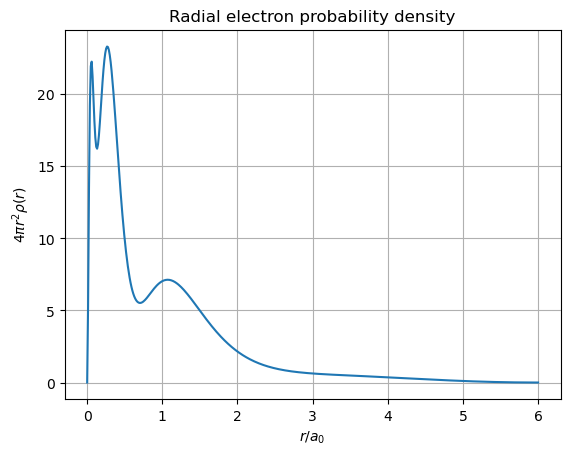

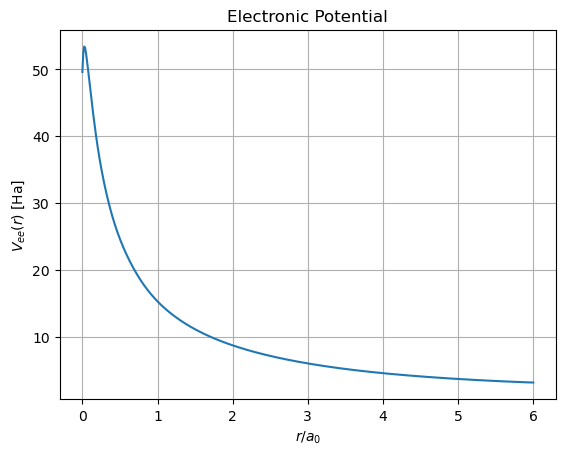

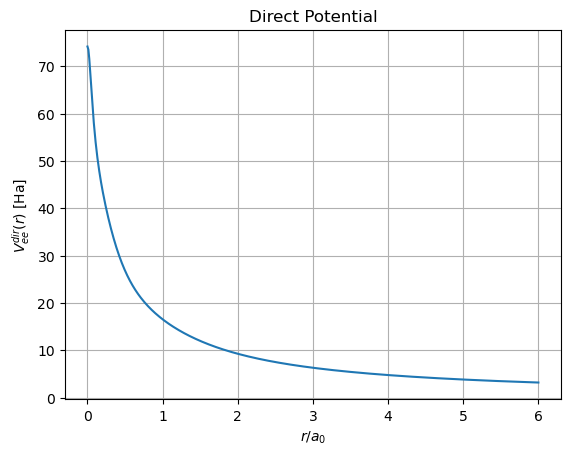

In [31]:
plt.plot(r_vals, 4*np.pi*r_vals**2 * total_rho_r )
plt.title("Radial electron probability density")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r"$4\pi r^2 \rho(r)$")
plt.grid()
plt.show()

plt.plot(r_vals, V_final)
plt.title("Electronic Potential")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$V_{ee}(r)$ [Ha]')
plt.grid()
plt.show()

plt.plot(r_vals, V_dir_ee_new)
plt.title("Direct Potential")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$V_{ee}^{dir}(r)$ [Ha]')
plt.grid()
plt.show()

Converged in 16 iterations.
potential expectation value:  1.2335320988177276
Total energy = -2.704253 Hartree
E=-0.735 Ha


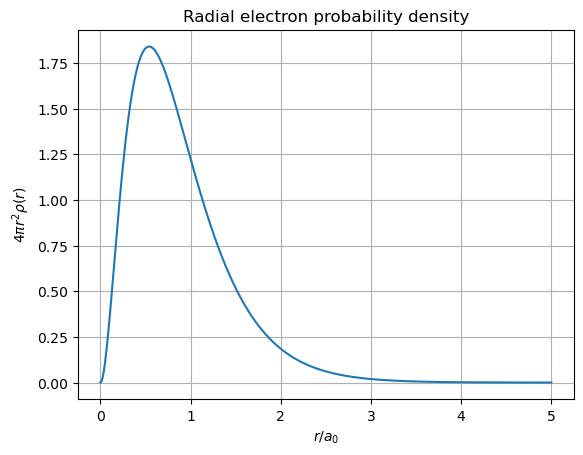

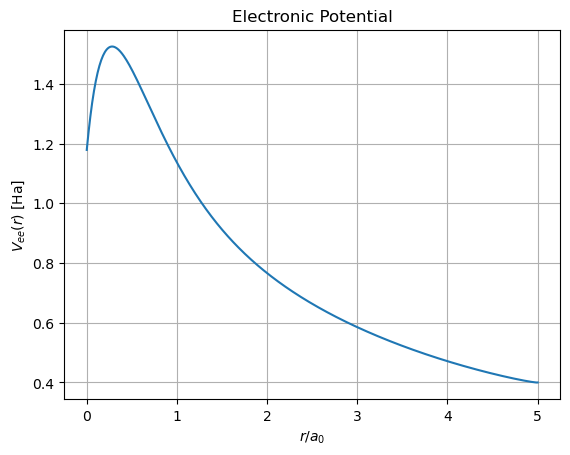

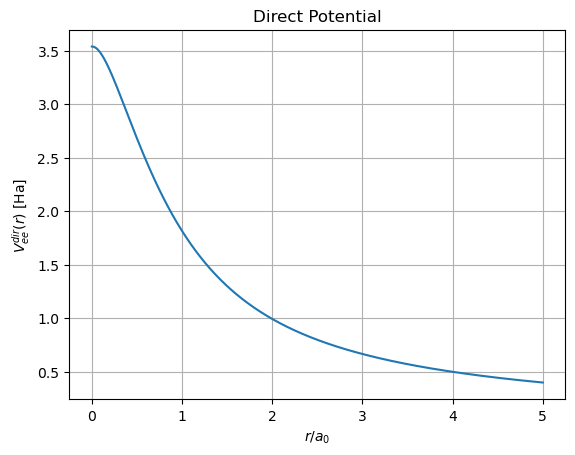

Normalization = 2.00000


In [ ]:
def knotssq(a, b, N_linear, N_nonuniform, transition, scheme):
    linear_knots = np.linspace(a, transition, N_linear, endpoint=False)
    
    if scheme == 'exponential':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * (np.exp(s) - 1) / (np.e - 1)
    elif scheme == 'quadratic':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * s**2
    elif scheme == 'linear':
        nonuniform_knots = np.linspace(transition, b, N_nonuniform)
    
    return np.concatenate((linear_knots, nonuniform_knots))

a, b = 0.0, 5.0
transition = 2.0 
N_linear = 30    
N_nonuniform = 10

#nknots = 5 
#knots = np.linspace(a, b, nknots)
knots = knotssq(a, b, N_linear, N_nonuniform, transition, scheme='exponential')
degree = 3       
augmented_knots = np.concatenate((np.repeat(knots[0], degree), knots, np.repeat(knots[-1], degree)))
n_basis = len(augmented_knots) - degree - 1
collocation_pts = knots  

def B(augmented_knots, degree, n_basis, nquad):
    unique_knots = collocation_pts
    B_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        a_int = unique_knots[i_int]
        b_int = unique_knots[i_int + 1]
        if np.isclose(b_int, a_int):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (b_int - a_int) * x_quad + 0.5 * (b_int + a_int)
        w_mapped = 0.5 * (b_int - a_int) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
    
        for i in range(n_basis):
            for j in range(i, n_basis):
                integrand = B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * integrand)
                B_matrix[i, j] += integral_value
                if i != j:
                    B_matrix[j, i] += integral_value
    return B_matrix

B_matrix = B(augmented_knots, degree, n_basis, nquad=5)
B_reduced = B_matrix[1:-1, 1:-1] 

def spherical_potential(r, Z, R0):
    return np.where(r < R0, -Z * ((3.0/(2*R0)) - (r**2)/(2*R0**3)), -Z / r)

def H(augmented_knots, degree, n_basis, nquad, l, Z, R0=None, V_ee_interp=None):
    unique_knots = collocation_pts
    H_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        t_start = unique_knots[i_int]
        t_end = unique_knots[i_int + 1]
        if np.isclose(t_end, t_start):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (t_end - t_start) * x_quad + 0.5 * (t_end + t_start)
        w_mapped = 0.5 * (t_end - t_start) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        B_der_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
            B_der_vals[i, :] = spline.derivative(nu=1)(x_mapped)

        if R0 is not None:
            V_nuclear = spherical_potential(x_mapped, Z, R0)
        else:
            V_nuclear = -Z / x_mapped
        
        V_eff = V_nuclear + (l * (l + 1)) / (2.0 * x_mapped**2)

        if V_ee_interp is not None:
            V_ee_vals = V_ee_interp(x_mapped)
            V_eff += V_ee_vals  

        for i in range(n_basis):
            for j in range(i, n_basis):
                kinetic_integrand = 0.5 * B_der_vals[i, :] * B_der_vals[j, :]
                potential_integrand = V_eff * B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * (kinetic_integrand + potential_integrand))
                H_matrix[i, j] += integral_value
                if i != j:
                    H_matrix[j, i] += integral_value
    return H_matrix

A = np.zeros((len(collocation_pts), n_basis))
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1  
    B_j = BSpline(augmented_knots, coeffs, degree)
    B_j_dd = B_j.derivative(nu=2)
    A[:, j] = B_j_dd(collocation_pts)

new_row = np.zeros(n_basis)
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    new_row[j] = B_j(b)
A_bc = np.vstack([A, new_row])   
A_reduced = A_bc[:, 1:]

l = 0     
Z = 2
r_vals = np.linspace(a+0.0000000001, b, 500)
occupied_states = [(0, 2)]  

max_iter = 50
tolerance = 1e-6
eta = 0.4 

V_dir_ee_old = np.zeros_like(r_vals)
E_old = None

for iteration in range(max_iter):
    V_ee_interp = interp1d(r_vals, V_dir_ee_old, kind='cubic', fill_value="extrapolate")

    H_matrix = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=None, V_ee_interp=V_ee_interp)
    H_reduced = H_matrix[1:-1, 1:-1]
    eigenvalues, eigenvectors = eigh(H_reduced, B_reduced)
    
    c_full = np.zeros((n_basis, eigenvectors.shape[1]))
    c_full[1:-1, :] = eigenvectors
    
    rho_r = np.zeros_like(r_vals)
    for idx, occ in occupied_states:
        phi_spline = BSpline(augmented_knots, c_full[:, idx], degree, extrapolate=False)
        P_vals = phi_spline(r_vals)
        rho_r += (occ/ (4 * np.pi)) * (P_vals / r_vals)**2


    V_exch_ee = - 3*((3*rho_r)/(8*np.pi))**(1/3) 

    rho_interp = interp1d(r_vals, rho_r, kind='cubic', fill_value="extrapolate")
    rho_collocation = rho_interp(collocation_pts)
    rhs = -collocation_pts * 4 * np.pi * rho_collocation
    b_bc = np.append(rhs, Z)
    c_reduced = np.linalg.solve(A_reduced, b_bc)
    c_full_potential = np.insert(c_reduced, 0, 0.0)
    phi_spline = BSpline(augmented_knots, c_full_potential, degree)
    phi_vals = phi_spline(r_vals)
    V_dir_ee_new = phi_vals / r_vals

    V_total_ee_new = V_dir_ee_new + V_exch_ee

    V_dir_ee_mixed = (1 - eta) * V_total_ee_new + eta * V_dir_ee_old

    if E_old is not None and abs(eigenvalues[0] - E_old) < tolerance:
        print(f"Converged in {iteration+1} iterations.")
        break

    E_old = eigenvalues[0]
    V_dir_ee_old = V_dir_ee_mixed

else:
    print("SCF did not converge after max iterations.")

V_final = V_dir_ee_old 

E_total = 0.0
for idx, occ in occupied_states:
    phi_spline = BSpline(augmented_knots, c_full[:, idx], degree, extrapolate=False)
    P_vals = phi_spline(r_vals)
    expectation = simpson(P_vals * V_final * P_vals, r_vals)
    print("potential expectation value: ", expectation)
    E_total += occ * (eigenvalues[idx] - 0.5 * expectation)

print(f"Total energy = {E_total:.6f} Hartree")
print(f"E={eigenvalues[0]:.3f} Ha")

plt.plot(r_vals, 4*np.pi*r_vals**2 * rho_r)
plt.title("Radial electron probability density")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r"$4\pi r^2 \rho(r)$")
plt.grid()
plt.show()

plt.plot(r_vals, V_final)
plt.title("Electronic Potential")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$V_{ee}(r)$ [Ha]')
plt.grid()
plt.show()

plt.plot(r_vals, V_dir_ee_new)
plt.title("Direct Potential")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$V_{ee}^{dir}(r)$ [Ha]')
plt.grid()
plt.show()

integral = simpson(4*np.pi*r_vals**2 * rho_r, r_vals)
print(f'Normalization = {integral:.5f}')